In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATE_COL = "date"
TARGET_COL = "total_flow"

ROOT = Path.cwd().parent   
DATA_PATH = ROOT / "dataset" / "card_usage" / "card_subway_transform_cleaned.csv"

df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL], low_memory=False)


# numeric cleanup
for col in ["boardings", "alightings", "latitude", "longitude", "station_code", "seoulmetro_code", TARGET_COL]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# weekend -> int
if "is_weekend" in df.columns:
    df["is_weekend"] = pd.to_numeric(df["is_weekend"], errors="coerce").fillna(0).astype(int)
else:
    df["is_weekend"] = (df[DATE_COL].dt.weekday >= 5).astype(int)

# station_key
code = None
if "seoulmetro_code" in df.columns:
    code = df["seoulmetro_code"]
elif "station_code" in df.columns:
    code = df["station_code"]

if code is not None:
    code_int = code.fillna(-1).astype(int)
    df["station_key"] = np.where(
        code.notna() & (code.astype(float) > 0),
        code_int.astype(str),
        df["line"].astype(str) + "|" + df["station_kr"].astype(str)
    )
else:
    df["station_key"] = df["line"].astype(str) + "|" + df["station_kr"].astype(str)

df = df.sort_values(["station_key", DATE_COL]).reset_index(drop=True)

In [3]:
# features
df["day_of_week_num"] = df[DATE_COL].dt.dayofweek
df["day_of_month"] = df[DATE_COL].dt.day
df["week_of_year"] = df[DATE_COL].dt.isocalendar().week.astype(int)

df["flow_ratio"] = df["boardings"] / (df["alightings"] + 1)
df["flow_diff"] = df["boardings"] - df["alightings"]

LAGS = [1, 7, 14]
for lag in LAGS:
    df[f"flow_lag_{lag}"] = df.groupby("station_key")[TARGET_COL].shift(lag)

ROLL_WINDOWS = [7, 14]
for w in ROLL_WINDOWS:
    df[f"flow_roll_mean_{w}"] = df.groupby("station_key")[TARGET_COL].transform(
        lambda s: s.shift(1).rolling(w, min_periods=w).mean()
    )
    df[f"flow_roll_std_{w}"] = df.groupby("station_key")[TARGET_COL].transform(
        lambda s: s.shift(1).rolling(w, min_periods=w).std()
    )

# target: next day flow
df["target"] = df.groupby("station_key")[TARGET_COL].shift(-1)

FEATURES = [
    "flow_lag_1","flow_lag_7","flow_lag_14",
    "flow_roll_mean_7","flow_roll_mean_14",
    "flow_roll_std_7","flow_roll_std_14",
    "flow_ratio","flow_diff",
    "day_of_week_num","day_of_month","week_of_year",
    "is_weekend"
]
for g in ["latitude", "longitude"]:
    if g in df.columns:
        FEATURES.append(g)

needed = FEATURES + ["target", DATE_COL, "station_key"]
df_model = df.dropna(subset=needed).reset_index(drop=True)

In [4]:

# time split 
split_date = df_model[DATE_COL].quantile(0.8)
train_df = df_model[df_model[DATE_COL] <= split_date]
val_df   = df_model[df_model[DATE_COL] >  split_date]

X_train, y_train = train_df[FEATURES], train_df["target"]
X_val, y_val = val_df[FEATURES], val_df["target"]

# Baseline: yesterday flow
baseline_pred = val_df["flow_lag_1"]
baseline_mae = mean_absolute_error(y_val, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))

print("Baseline Results")
print(f"MAE  : {baseline_mae:,.2f}")
print(f"RMSE : {baseline_rmse:,.2f}")
print("-"*40)


Baseline Results
MAE  : 11,342.17
RMSE : 23,829.96
----------------------------------------


In [5]:
# Export the dataset with new time series features
export_path = ROOT / "dataset" / "card_usage" / "card_subway_with_timeseries_features.csv"
df.to_csv(export_path, index=False, encoding="utf-8-sig")
print(f"Exported dataset with time series features to {export_path}")

Exported dataset with time series features to /Users/melvinang/Documents/NUS/Y4 Winter/Team7/IEE3593_Team7/dataset/card_usage/card_subway_with_timeseries_features.csv


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'num_leaves': [31, 63, 127, 255],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'n_estimators': [500, 1000, 3000, 5000],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

model = LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best MAE (CV):", -random_search.best_score_)

# Use the best model for validation
best_model = random_search.best_estimator_
val_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print("LightGBM Results (Best Model)")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print("-"*40)
print("Improvement over baseline")
print(f"MAE improvement  : {(baseline_mae - mae) / baseline_mae * 100:.2f}%")
print(f"RMSE improvement : {(baseline_rmse - rmse) / baseline_rmse * 100:.2f}%")

feat_imp = pd.DataFrame({"feature": FEATURES, "importance": best_model.feature_importances_}).sort_values("importance", ascending=False)
print("Top Features")
print(feat_imp.head(15).to_string(index=False))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2879
[LightGBM] [Info] Number of data points in the train set: 1497824, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 1497825, number of used features: 15
[LightGBM] [Info] Start training from score 26141.407129
[LightGBM] [Info] Start training from score 22794.579486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159418 seconds.
You can s

/var/folders/08/pmnk96px7x94djx_0kg9f2zh0000gn/T/ipykernel_88572/3034449468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = model.predict(X_val)
/var/folders/08/pmnk96px7x94djx_0kg9f2zh0000gn/T/ipykernel_88572/3034449468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["residual"] = val_df["pred"] - val_df["target"]


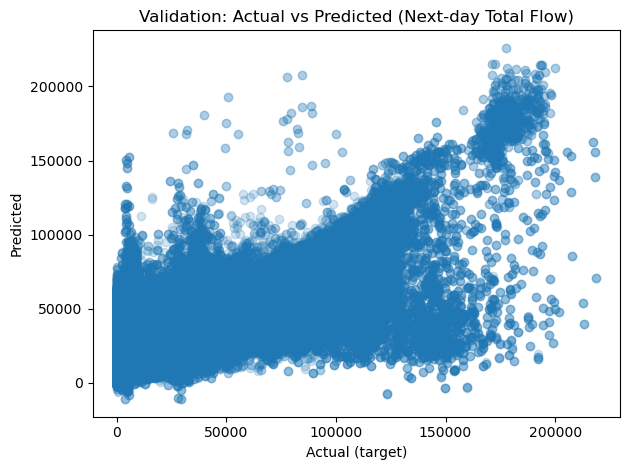

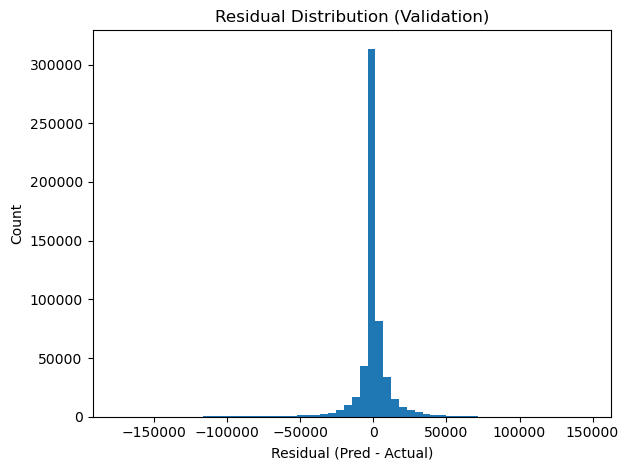

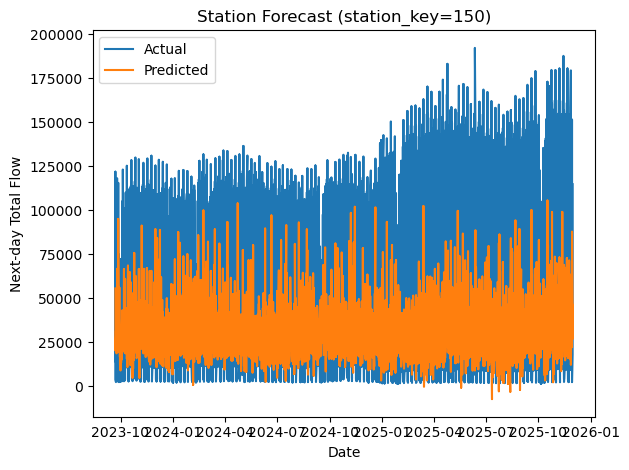

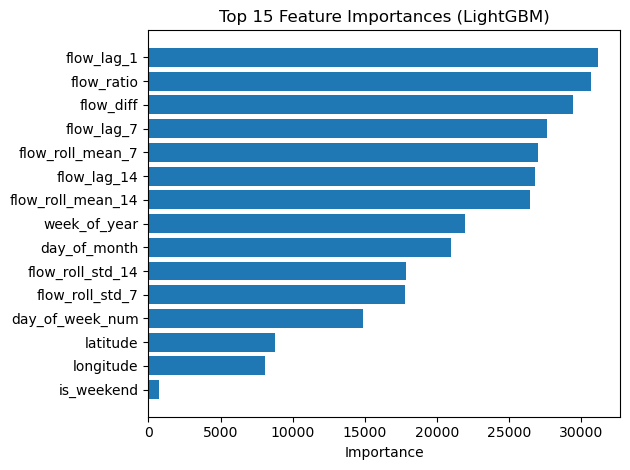

In [ ]:
# Assign predictions and residuals to val_df
val_df["pred"] = model.predict(X_val)
val_df["residual"] = val_df["pred"] - val_df["target"]

# PLOT 1: Actual vs Pred (scatter)
plt.figure()
plt.scatter(val_df["target"], val_df["pred"], alpha=0.2)
plt.xlabel("Actual (target)")
plt.ylabel("Predicted")
plt.title("Validation: Actual vs Predicted (Next-day Total Flow)")
plt.tight_layout()
plt.show()

# PLOT 2: Residual distribution
plt.figure()
plt.hist(val_df["residual"], bins=60)
plt.xlabel("Residual (Pred - Actual)")
plt.ylabel("Count")
plt.title("Residual Distribution (Validation)")
plt.tight_layout()
plt.show()

# PLOT 3: Time-series plot for one station
# Choose a station with many rows in val set
station_counts = val_df["station_key"].value_counts()
example_station = station_counts.index[0]  # most frequent in val
station_df = val_df[val_df["station_key"] == example_station].sort_values(DATE_COL)

plt.figure()
plt.plot(station_df[DATE_COL], station_df["target"], label="Actual")
plt.plot(station_df[DATE_COL], station_df["pred"], label="Predicted")
plt.xlabel("Date")
plt.ylabel("Next-day Total Flow")
plt.title(f"Station Forecast (station_key={example_station})")
plt.legend()
plt.tight_layout()
plt.show()

# PLOT 4: Feature importance (top 15)
imp = pd.DataFrame({
    "feature": FEATURES,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False).head(15)

plt.figure()
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()
